In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#plt.style.use('dark_background')
#plt.style.use('ggplot')

C:\Users\Andres\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [111]:
gold = pd.read_csv('data/data.csv',  encoding='unicode_escape')
gold.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [112]:
gold = gold[["Date", "Close"]]

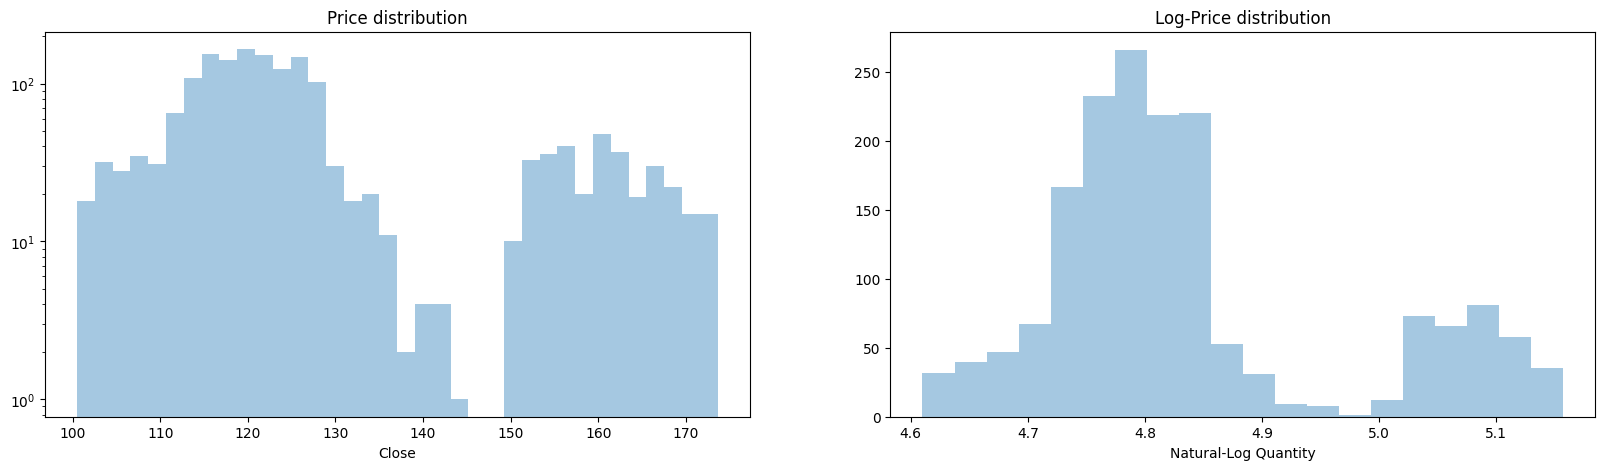

In [113]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(gold.Close, ax=ax[0], kde=False);
sns.distplot(np.log(gold.Close), ax=ax[1], bins=20, kde=False);
ax[0].set_title("Price distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Price distribution")
ax[1].set_xlabel("Natural-Log Quantity");


#### Outliers

In [114]:
gold.shape

(1718, 2)

In [115]:
missing_values = gold.isnull().sum()
missing_values

Date     0
Close    0
dtype: int64

In [118]:
gold['Date'] = pd.to_datetime(gold['Date'])
gold

,Date,Close
0,2011-12-15,152.330002
1,2011-12-16,155.229996
2,2011-12-19,154.869995
3,2011-12-20,156.979996
4,2011-12-21,157.160004
...,...,...
1713,2018-12-24,120.019997
1714,2018-12-26,119.660004
1715,2018-12-27,120.570000
1716,2018-12-28,121.059998


In [119]:
gold['Date'].info

<bound method Series.info of 0      2011-12-15
1      2011-12-16
2      2011-12-19
3      2011-12-20
4      2011-12-21
          ...    
1713   2018-12-24
1714   2018-12-26
1715   2018-12-27
1716   2018-12-28
1717   2018-12-31
Name: Date, Length: 1718, dtype: datetime64[ns]>

In [120]:
gold = gold.set_index('Date')

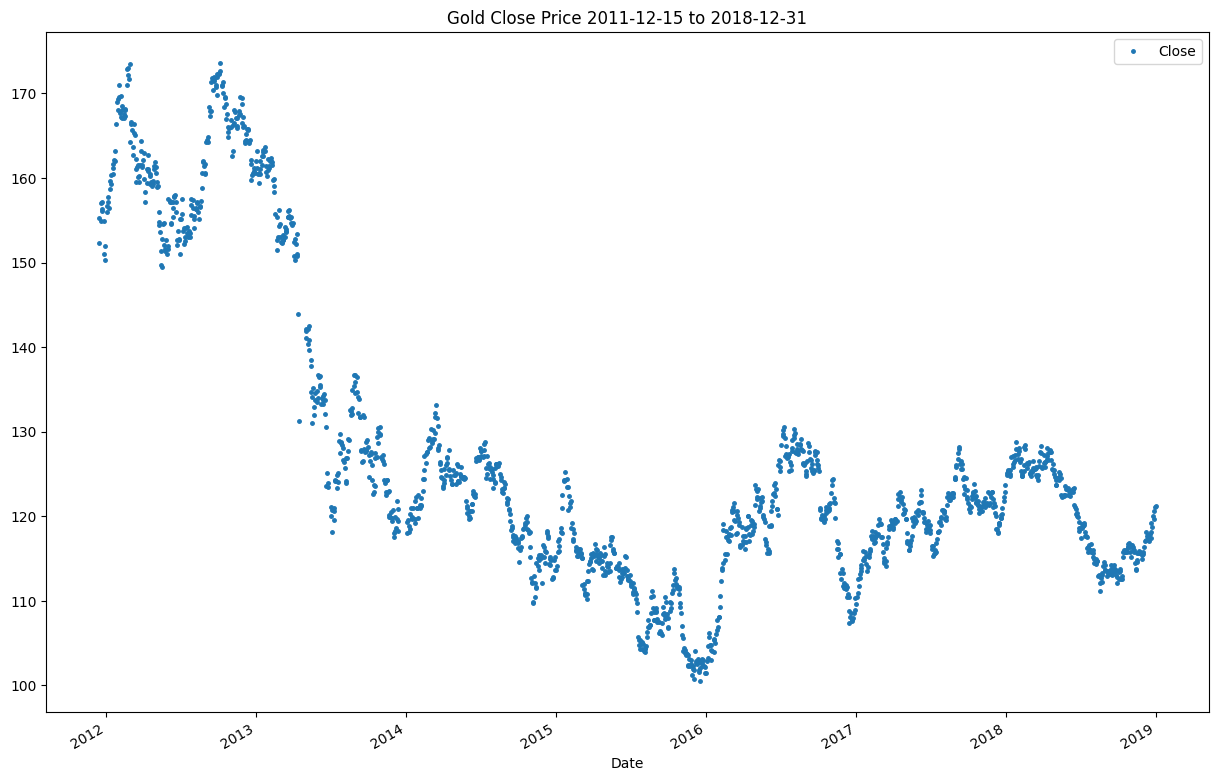

In [121]:
color_pal = sns.color_palette()

gold.plot(style='.', figsize=(15,10), ms=5, color=color_pal[0], title="Gold Close Price 2011-12-15 to 2018-12-31")
plt.show()

<Axes: >

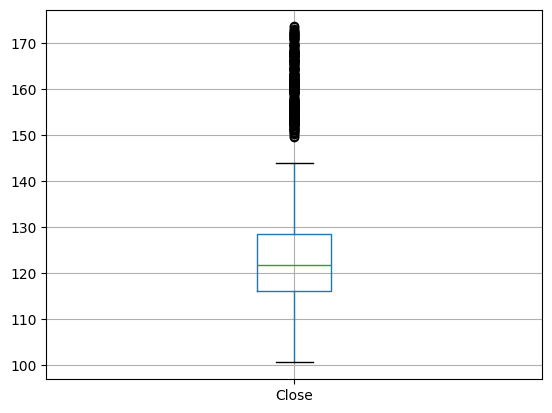

In [122]:
gold.boxplot()

In [123]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(gold, label='Close')
features_and_target = pd.concat([X, y], axis=1)

In [124]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekday,season,Close
Date,,,,,,,,,,
2011-12-15,0,3,4,12,2011,349,15,Thursday,Fall,152.330002
2011-12-16,0,4,4,12,2011,350,16,Friday,Fall,155.229996
2011-12-19,0,0,4,12,2011,353,19,Monday,Fall,154.869995
2011-12-20,0,1,4,12,2011,354,20,Tuesday,Fall,156.979996
2011-12-21,0,2,4,12,2011,355,21,Wednesday,Winter,157.160004
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0,0,4,12,2018,358,24,Monday,Winter,120.019997
2018-12-26,0,2,4,12,2018,360,26,Wednesday,Winter,119.660004
2018-12-27,0,3,4,12,2018,361,27,Thursday,Winter,120.570000


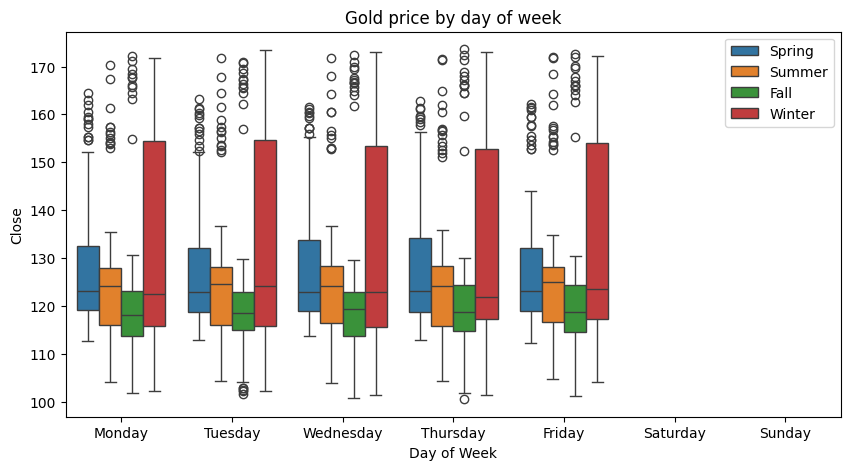

In [125]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Close',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Gold price by day of week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Close')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Just to see... Maximum of 2012 and 2013 winter showing

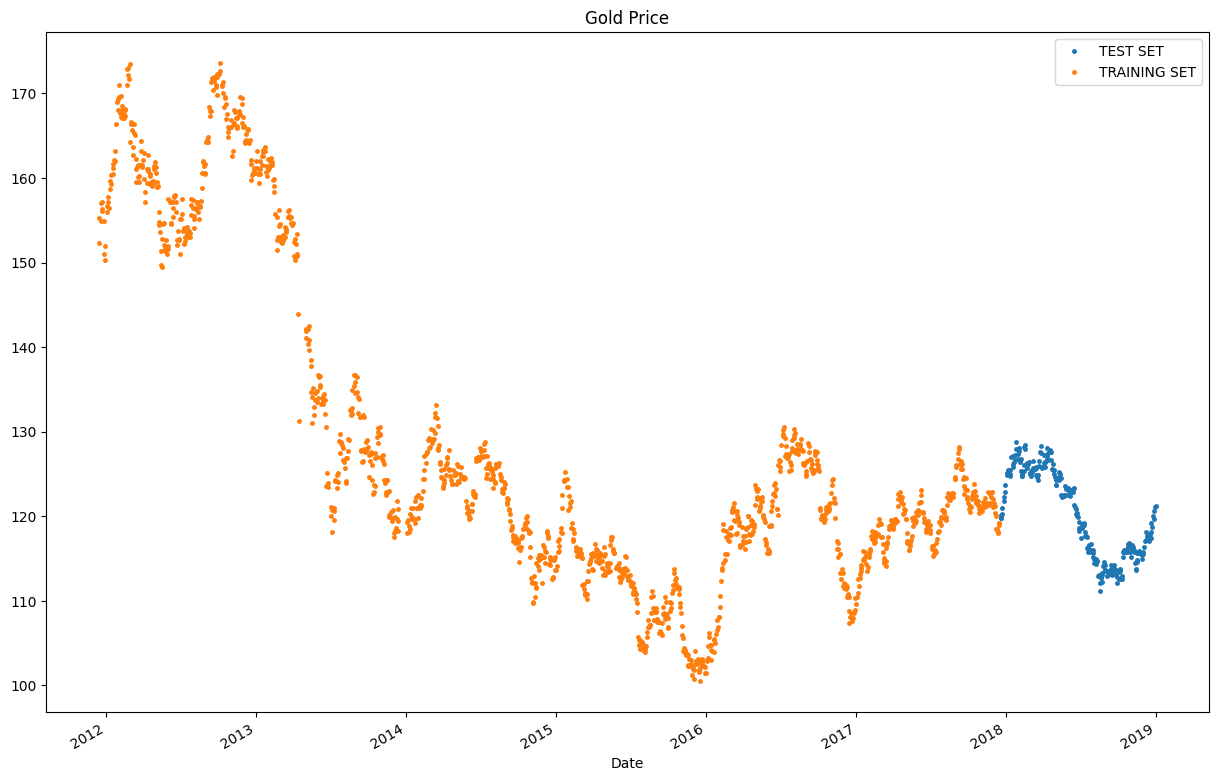

In [126]:
# 1718
# let's keep 85% for training and 15% for test
# 85% == 1460 == 2017-12-15


split_date = '15-Dec-2017'
gold_train = gold.loc[gold.index <= split_date].copy()
gold_test = gold.loc[gold.index > split_date].copy()

gold_test \
    .rename(columns={'Close': 'TEST SET'}) \
    .join(gold_train.rename(columns={'Close': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15, 10), title='Gold Price', style='.', ms=5)
plt.show()

# FB Prophet Model

In [127]:
gold_train_prophet = gold_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})


In [128]:
gold_train_prophet

,ds,y
0,2011-12-15,152.330002
1,2011-12-16,155.229996
2,2011-12-19,154.869995
3,2011-12-20,156.979996
4,2011-12-21,157.160004
...,...,...
1456,2017-12-11,118.010002
1457,2017-12-12,118.150002
1458,2017-12-13,119.169998
1459,2017-12-14,118.930000


In [129]:
%%time
model = Prophet()
model.fit(gold_train_prophet)

10:53:43 - cmdstanpy - INFO - Chain [1] start processing
10:53:43 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 109 ms
Wall time: 630 ms


In [130]:
gold_test_prophet = gold_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

In [131]:
gold_test_forecast = model.predict(gold_test_prophet)

In [144]:
gold_test_forecast.ds = pd.to_datetime(gold_test_forecast.ds)
gold_test_forecast.set_index(gold_test_forecast.ds)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2017-12-18,2017-12-18,118.640488,110.537347,117.895562,118.640488,118.640488,-4.418651,-4.418651,-4.418651,2.429141,2.429141,2.429141,-6.847792,-6.847792,-6.847792,0.0,0.0,0.0,114.221838
2017-12-19,2017-12-19,118.648181,110.394277,117.452343,118.648181,118.648181,-4.625856,-4.625856,-4.625856,2.423722,2.423722,2.423722,-7.049579,-7.049579,-7.049579,0.0,0.0,0.0,114.022325
2017-12-20,2017-12-20,118.655874,110.063593,117.027795,118.655874,118.655874,-4.851762,-4.851762,-4.851762,2.379512,2.379512,2.379512,-7.231274,-7.231274,-7.231274,0.0,0.0,0.0,113.804112
2017-12-21,2017-12-21,118.663567,110.263299,117.322861,118.663567,118.663567,-4.980652,-4.980652,-4.980652,2.408775,2.408775,2.408775,-7.389427,-7.389427,-7.389427,0.0,0.0,0.0,113.682915
2017-12-22,2017-12-22,118.671260,109.784397,117.227381,118.671260,118.671260,-5.049898,-5.049898,-5.049898,2.471012,2.471012,2.471012,-7.520910,-7.520910,-7.520910,0.0,0.0,0.0,113.621362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,121.494553,71.289239,160.235668,76.100406,164.726784,-5.249717,-5.249717,-5.249717,2.429141,2.429141,2.429141,-7.678858,-7.678858,-7.678858,0.0,0.0,0.0,116.244836
2018-12-26,2018-12-26,121.509938,71.883288,159.202608,75.951644,165.006621,-5.355750,-5.355750,-5.355750,2.379512,2.379512,2.379512,-7.735262,-7.735262,-7.735262,0.0,0.0,0.0,116.154188
2018-12-27,2018-12-27,121.517631,70.334088,159.715410,75.844775,165.278765,-5.302201,-5.302201,-5.302201,2.408775,2.408775,2.408775,-7.710976,-7.710976,-7.710976,0.0,0.0,0.0,116.215430


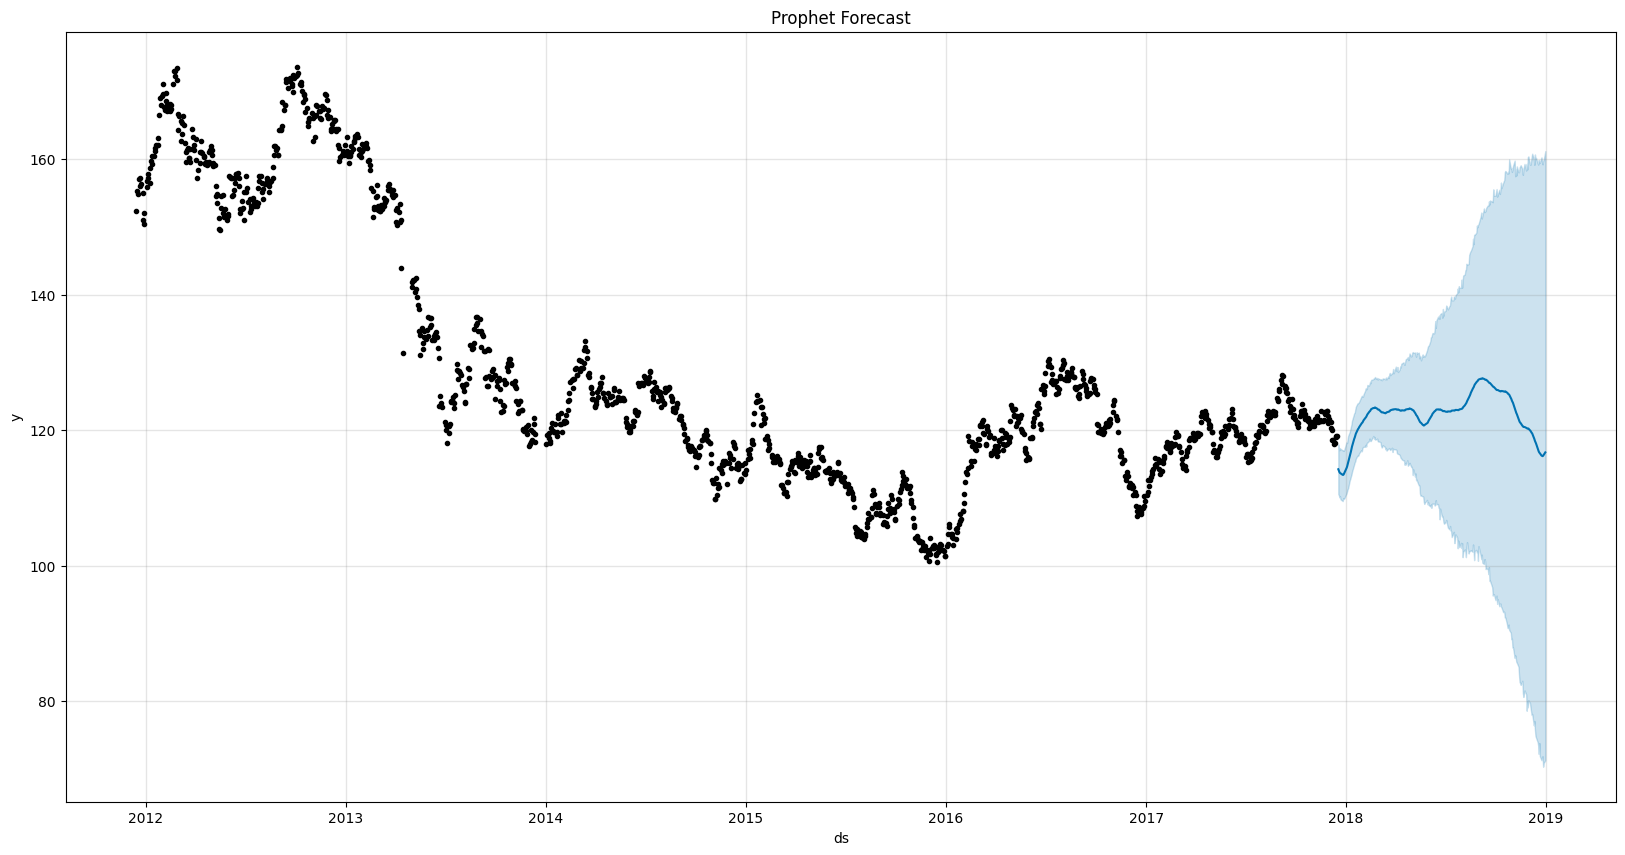

In [145]:
fig, ax = plt.subplots(figsize=(20, 10))
fig = model.plot(gold_test_forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

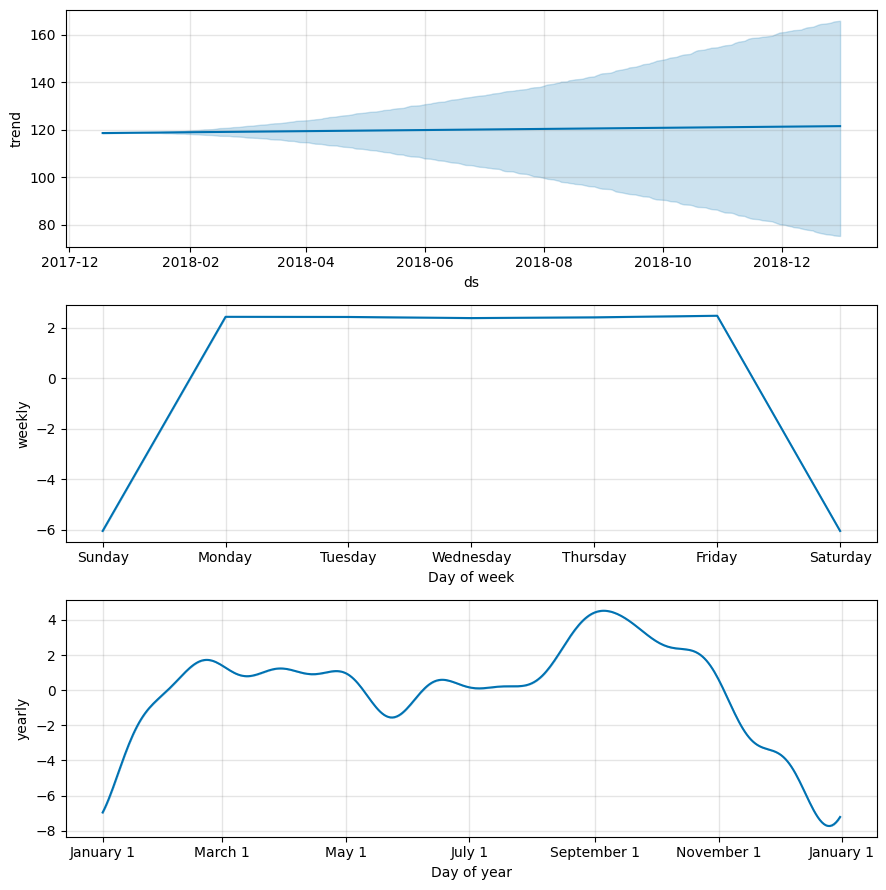

In [146]:
fig = model.plot_components(gold_test_forecast)
plt.show()

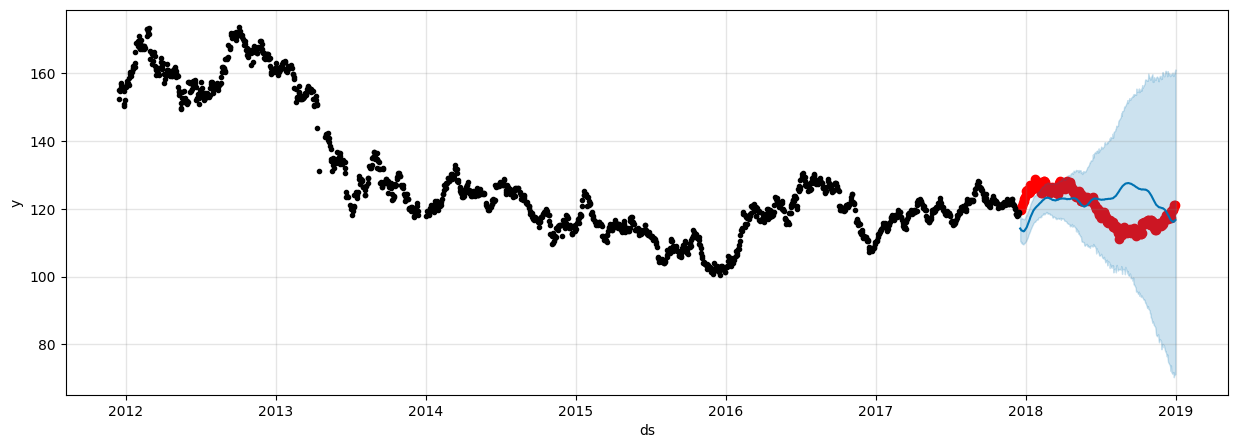

In [147]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(gold_test.index, gold_test['Close'], color='r')
fig = model.plot(gold_test_forecast, ax=ax)



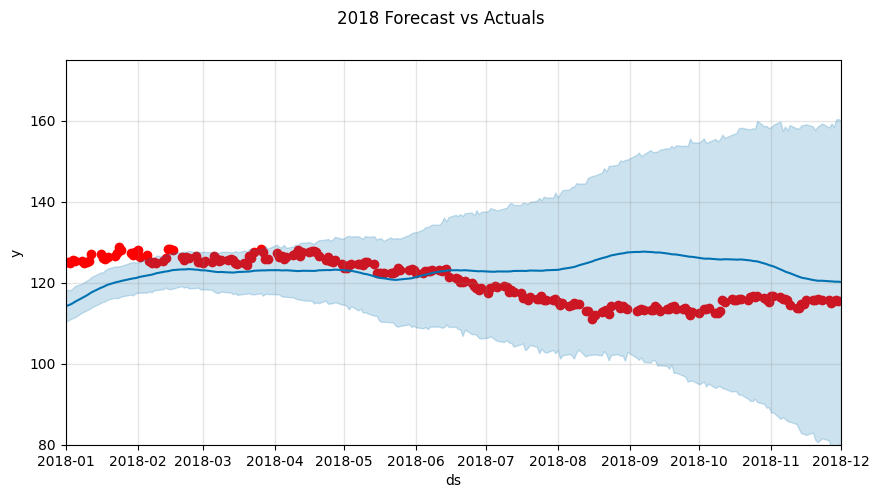

In [163]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(gold_test.index, gold_test['Close'], color='r')
fig = model.plot(gold_test_forecast, ax=ax)
ax.set_xbound(lower= pd.to_datetime('2018-01-01'),
              upper= pd.to_datetime('2018-12-01'))
ax.set_ylim(80, 175)
plot = plt.suptitle('2018 Forecast vs Actuals')

# Obtaining Error Metrics

In [159]:
np.sqrt(mean_squared_error(y_true=gold_test['Close'],
                   y_pred=gold_test_forecast['yhat']))

7.303274150233194

In [161]:
mean_absolute_error(y_true=gold_test['Close'],
                   y_pred=gold_test_forecast['yhat'])


6.058532865466457

In [162]:
mean_absolute_percentage_error(y_true=gold_test['Close'],
                   y_pred=gold_test_forecast['yhat'])

5.139942849070219